In [1]:
import safep
import alchemlyb
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from alchemlyb.parsing import namd
from IPython.display import display, Markdown

from alchemlyb.estimators import BAR
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


# User parameters

In [2]:
path='/home/ems363/Projects/Lipid_ABFE/protein/POPG_protein_replica_01/outputs/'
filename='*.fepout'

temperature = 303.15
RT = 0.00198720650096 * temperature
decorrelate = True #Flag for decorrelation of samples
detectEQ = True #Flag for automated equilibrium detection

fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 80 fepout files.
Total size:0.08GB


# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to convert to units of kcal/mol.

fig, ax = plt.subplots()
u_nk = namd.extract_u_nk(fepoutFiles, temperature)
safep.plot_samples(ax, u_nk, color='blue', label='Raw Data')

if detectEQ:
    print("Detecting equilibrium")
    u_nk = safep.detect_equilibrium_u_nk(u_nk)
    safep.plot_samples(ax, u_nk, color='orange', label='Equilibrium-Detected')
if decorrelate:
    print("Decorrelating")
    u_nk = safep.decorrelate_u_nk(u_nk)
    safep.plot_samples(ax, u_nk, color='green', label='Decorrelated')
    
plt.savefig(f"{path}FEP_number_of_samples.pdf")

In [5]:
perWindow, cumulative = safep.do_estimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = safep.do_convergence(u_nk) #Used later in the convergence plot'
per_lambda_convergence = safep.do_per_lambda_convergence(u_nk)

In [6]:
dG = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)

changeAndError = f'\u0394G = {dG}\u00B1{error} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

<font size=5>ΔG = 150.2±0.4 kcal/mol</font><br/>

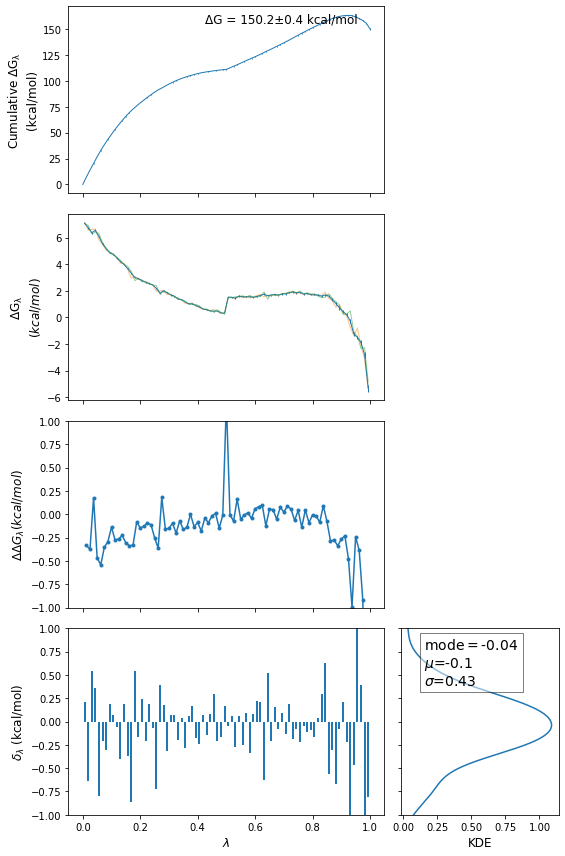

In [7]:
fig, axes = safep.plot_general(cumulative, None, perWindow, None, RT)
fig.suptitle(changeAndError)
plt.savefig(f'{path}FEP_general_figures.pdf')

# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

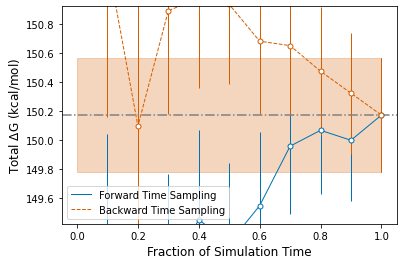

In [8]:
fig, convAx = plt.subplots(1,1)
convAx = safep.convergence_plot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)
plt.savefig(f'{path}FEP_convergence.pdf')

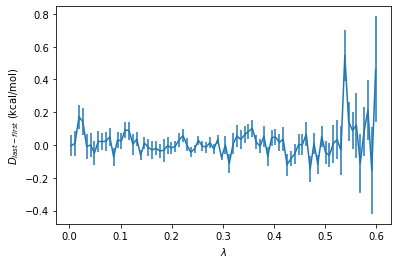

In [11]:
fig, ax = plt.subplots()
ax.errorbar(per_lambda_convergence.index*RT, per_lambda_convergence.BAR.df*RT, yerr=per_lambda_convergence.BAR.ddf*RT)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$D_{last-first}$ (kcal/mol)")
plt.savefig(f"{path}FEP_perLambda_convergence.pdf")